In [ ]:
# std lib
from getpass import getpass
import random

# 3rd party 
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from sparcl.client import SparclClient

import numpy as np
import healpy as hp
import sys

<a class="anchor" id="async"></a>
# ALLWISE

In [77]:
query = """
SELECT 
S.w1mpro as w1, S.w2mpro as w2, S.designation as designation, S.ra as ra, S.dec as dec, S.ring256 as ring256, S.w1snr as w1snr, S.w2snr as w2snr, S.cc_flags as cc_flags, S.glat as lat, S.glon as lon
FROM allwise.source as S
WHERE ((S.w1mpro - S.w2mpro) > 0.65*EXP((0.153*POWER(ABS(S.w2mpro-13.86),2))) AND S.w2mpro > 13.86) 
OR ((S.w1mpro - S.w2mpro) > 0.65 AND S.w2mpro < 13.86) 
"""

In [78]:
final_table = qc.query(sql=query, timeout = 100000, out='mydb://allwise_firstpass', drop=True)
print(final_table)

OK


In [79]:
#ALLWISE
new_query = """
SELECT *
FROM mydb://allwise_firstpass
WHERE w1 > 8 AND w2 > 7 AND w1snr>3 AND w2snr>5 AND CAST(cc_flags as char)='0'
"""

In [80]:
final_table = qc.query(sql=new_query, timeout = 100000, out='mydb://allwise_errorcuts', drop=True)
print(final_table)

OK


In [81]:
query = """
SELECT *
FROM mydb://allwise_errorcuts
WHERE NOT q3c_radial_query(lon, lat, 0, 0, 30) AND (lat > 10 or lat < -10)
"""
final_table = qc.query(sql=query, timeout = 100000, out='mydb://allwise_center_errorcut', drop=True)
print(final_table)
print(qc.mydb_list())

OK
allwise_center_errorcut
allwise_errorcuts
allwise_firstpass
tbl_stat
unwise
unwise_center_errorcut
unwise_firstpass
unwise_mags
wise_table



In [82]:
#ALLWISE
test_table = qc.query('select ra from mydb://allwise_center_errorcut', fmt = 'pandas')
print(test_table)
test_table = qc.query('select COUNT(ra), ring256 from mydb://allwise_center_errorcut group by ring256', fmt = 'pandas')
print(test_table)

                 ra
0        326.659889
1        326.009765
2        326.236422
3        326.494454
4        326.457657
...             ...
4718561   44.642539
4718562   45.014456
4718563   45.011012
4718564   44.712968
4718565   44.908268

[4718566 rows x 1 columns]
        count  ring256
0           4    72397
1           6    92865
2           5    88451
3           5   133780
4           5     5468
...       ...      ...
615041      7   706926
615042      6   736706
615043     15   560047
615044     13   296863
615045      3   710096

[615046 rows x 2 columns]


In [83]:
test_table = test_table.sort_values(by=['ring256'])
ring256 = np.array(test_table.loc[:,'ring256'])
counts = np.array(test_table.loc[:,'count'])
empty_counts = np.zeros(hp.nside2npix(256))
for i in range(len(counts)):
    empty_counts[ring256[i]] = counts[i]


In [84]:
wise_data = qc.query('select * from mydb://wise_table', fmt = 'pandas')
print(wise_data)

            wise_designation          ra        dec  w1mpro  w1sigmpro  \
0        J000000.00-165522.3    0.000014 -16.922866  15.817      0.048   
1        J000000.01-422938.4    0.000053 -42.494019  16.774      0.086   
2        J000000.04+033452.5    0.000190   3.581275  15.568      0.047   
3        J000000.05-201340.3    0.000209 -20.227880  17.705      0.225   
4        J000000.06-223834.6    0.000259 -22.642965  16.429      0.078   
...                      ...         ...        ...     ...        ...   
4543525  J235959.86-041131.0  359.999427  -4.191963  17.954      0.290   
4543526  J235959.92-225422.8  359.999670 -22.906353  17.434      0.158   
4543527  J235959.93-073429.2  359.999722  -7.574794  16.723      0.103   
4543528  J235959.94-104318.0  359.999768 -10.721689  16.496      0.088   
4543529  J235959.96-093415.5  359.999833  -9.570972  14.812      0.032   

         w2mpro  w2sigmpro  w3mpro  w3sigmpro  w4mpro  w4sigmpro  \
0        14.934      0.066  12.146     -1.0

In [85]:
decl = wise_data.loc[:,'dec']
RA = wise_data.loc[:,'ra']
pixels = np.array(hp.pixelfunc.ang2pix(256,np.radians(-decl+90.),np.radians(360.+RA)))
pixels.sort()
frequency = {}
for i in range (0, 4543530):
    frequency[pixels[i]] = frequency.get(pixels[i], 0) + 1
keys = list(frequency.keys())
vals = list(frequency.values())

In [86]:
empty_wise_counts = np.zeros(hp.nside2npix(256))
for i in range(len(vals)):
    empty_wise_counts[keys[i]] = vals[i]

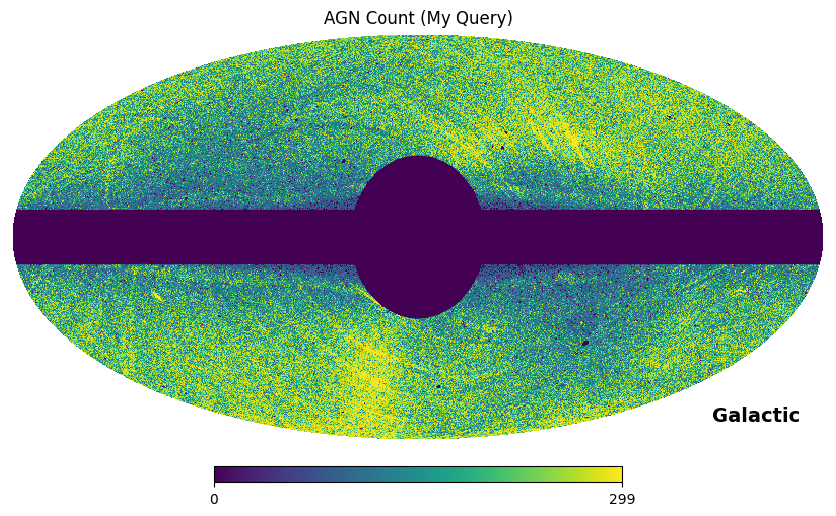

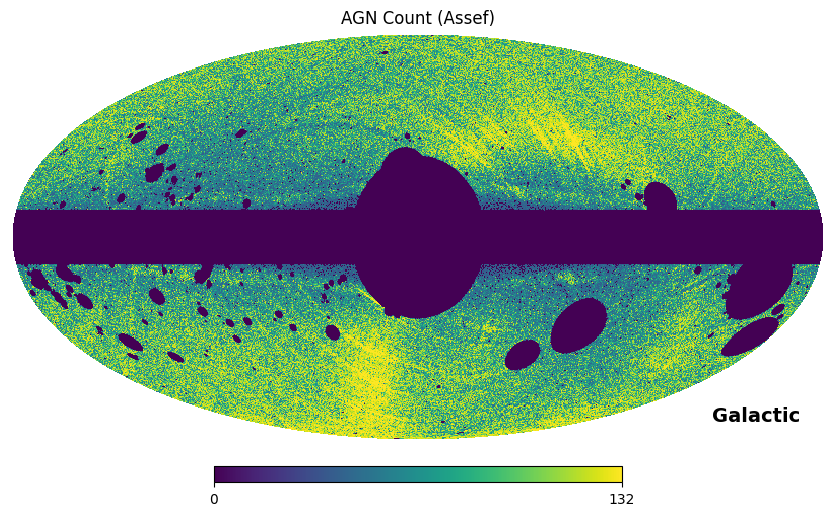

In [109]:
hp.mollview(empty_counts, title="AGN Count (My Query)", norm='hist',coord='CG')
hp.mollview(empty_wise_counts, title="AGN Count (Assef)", norm='hist',coord='CG')

In [91]:
hist_table = qc.query('select w1, w2, designation from mydb://allwise_center_errorcut', fmt = 'pandas')

In [94]:
hist_table.sort_values(by=['designation'])
print(hist_table.loc[:,'designation'])
print(wise_data.loc[:,'wise_designation'])

0          J214638.37+395610.8
1          J214402.34+395240.7
2          J214456.74+395131.4
3          J214558.66+394930.4
4          J214549.83+395320.1
                  ...         
4718561    J025834.20-352816.1
4718562    J030003.46-352452.6
4718563    J030002.64-352418.8
4718564    J025851.11-352417.4
4718565    J025937.98-352750.0
Name: designation, Length: 4718566, dtype: object
0          J000000.00-165522.3
1          J000000.01-422938.4
2          J000000.04+033452.5
3          J000000.05-201340.3
4          J000000.06-223834.6
                  ...         
4543525    J235959.86-041131.0
4543526    J235959.92-225422.8
4543527    J235959.93-073429.2
4543528    J235959.94-104318.0
4543529    J235959.96-093415.5
Name: wise_designation, Length: 4543530, dtype: object


In [108]:
d3 = hist_table.merge(wise_data, left_on='designation', right_on='wise_designation')[['w1', 'w2', 'designation','w1mpro','w2mpro']]
print(d3)
#d4 = wise_data[~wise_data.isin(hist_table).all(axis=1)]
d4 = hist_table.loc[~hist_table['designation'].isin(wise_data['wise_designation'])]
d5 = wise_data.loc[~wise_data['wise_designation'].isin(hist_table['designation'])][['wise_designation','w1mpro','w2mpro']]
print(d4)
print(d5)

             w1      w2          designation  w1mpro  w2mpro
0        17.792  16.231  J214638.37+395610.8  17.792  16.231
1        16.644  15.485  J214402.34+395240.7  16.644  15.485
2        16.060  15.147  J214456.74+395131.4  16.060  15.147
3        16.020  15.133  J214558.66+394930.4  16.020  15.133
4        15.362  14.402  J214549.83+395320.1  15.362  14.402
...         ...     ...                  ...     ...     ...
4271261  15.797  14.586  J025834.20-352816.1  15.797  14.586
4271262  14.494  13.689  J030003.46-352452.6  14.494  13.689
4271263  16.529  15.473  J030002.64-352418.8  16.529  15.473
4271264  15.926  14.754  J025851.11-352417.4  15.926  14.754
4271265  15.090  14.128  J025937.98-352750.0  15.090  14.128

[4271266 rows x 5 columns]
             w1      w2          designation
13       16.003  14.548  J214450.91+400354.0
15       16.402  15.401  J214436.75+400316.2
16       16.053  14.950  J214510.53+400655.2
18       16.567  15.504  J214815.33+400427.5
22       16.716

In [70]:
binning = np.arange(12,20,0.5)
binning2 = np.arange(12,17.5,0.5)

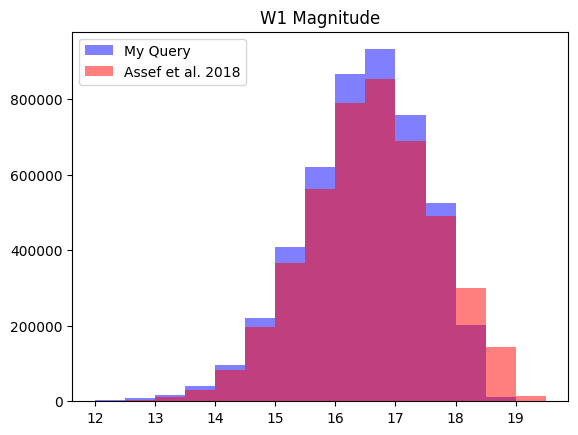

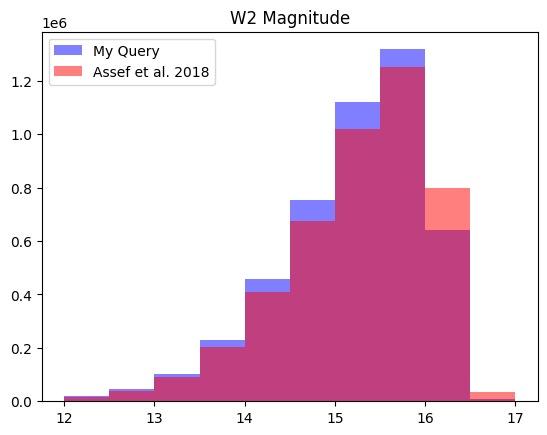

In [71]:
plt.hist(hist_table.loc[:,'w1'], bins = binning,label = "My Query", color = 'b', alpha = 0.5)
plt.hist(wise_data.loc[:,'w1mpro'], bins = binning,label = "Assef et al. 2018", color= 'r',alpha = 0.5)
plt.title("W1 Magnitude")
plt.legend()
plt.show()
plt.hist(hist_table.loc[:,'w2'], bins = binning2,label = "My Query", alpha = 0.5, color= 'b')
plt.hist(wise_data.loc[:,'w2mpro'], bins = binning2,label = "Assef et al. 2018", alpha = 0.5, color= 'r')
plt.title("W2 Magnitude")
plt.legend()
plt.show()

In [64]:
w21_my = hist_table.loc[:,'w1']-hist_table.loc[:,'w2']
w21_assef = wise_data.loc[:,'w1mpro']-wise_data.loc[:,'w2mpro']
w2 = hist_table.loc[:,'w2']
w2_assef = wise_data.loc[:,'w2mpro']

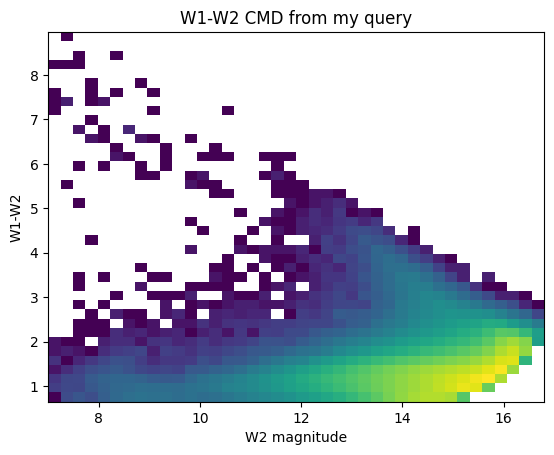

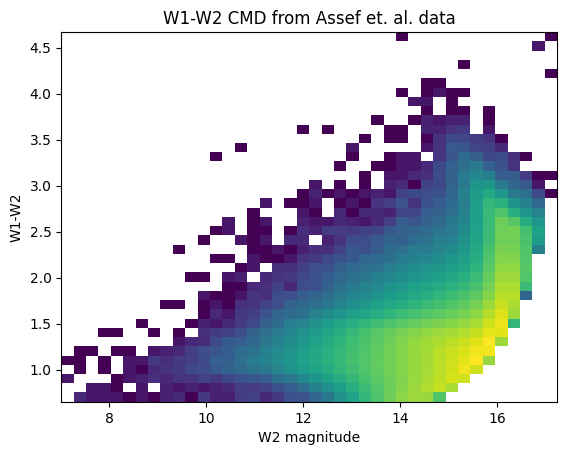

In [65]:
plt.hist2d(w2,w21_my, bins = 40,norm=matplotlib.colors.LogNorm())
plt.title("W1-W2 CMD from my query")
plt.xlabel('W2 magnitude')
plt.ylabel('W1-W2')
plt.show()
plt.hist2d(w2_assef,w21_assef,bins = 40,norm=matplotlib.colors.LogNorm())
plt.title("W1-W2 CMD from Assef et. al. data")
plt.ylabel('W1-W2')
plt.xlabel('W2 magnitude')
plt.show()

<a class="anchor" id="async"></a>
# unWISE

In [24]:
#UNWISE
squery = """
SELECT 
S.mag_w1_vg as w1, S.mag_w2_vg as w2, S.unwise_objid as id, S.ra as ra, S.dec as dec, S.ring256 as ring256, S.glat as lat, S.glon as lon
FROM unwise_dr1.object as S
WHERE S.mag_w2_vg > 7.032 AND S.mag_w1_vg > 8.004 AND (S.glat > 10 OR S.glat < -10)
"""

In [ ]:
new_table = qc.query(sql=squery, timeout = 1000000, out='mydb://unwise_mags', async_=True, poll=60, verbose = 1, wait=True, drop=True)
print(new_table)

In [41]:
print(qc.mydb_list())

allwise_center_errorcut
allwise_errorcuts
allwise_firstpass
tbl_stat
unwise
unwise_center_errorcut
unwise_firstpass
unwise_mags
wise_table



In [42]:
query = """
SELECT *
FROM mydb://unwise_mags
WHERE ((w1-w2-0.036) > 0.65*EXP((0.153*POWER(ABS(w2-13.892),2))) AND w2 > 13.892) OR ((w1-w2-0.036) > 0.65 AND w2 < 13.892) 
"""

In [43]:
#UNWISE
final_table = qc.query(sql=query, timeout = 1000000, out='mydb://unwise_firstpass', drop=True)
print(final_table)

OK


In [44]:
#UNWISE
query = """
SELECT *
FROM mydb://unwise_firstpass
WHERE NOT q3c_radial_query(lon, lat, 0, 0, 30)
"""
final_table = qc.query(sql=query, timeout = 100000, out='mydb://unwise_center_errorcut', drop=True)
print(final_table)

OK


In [46]:
#UNWISE
test_table = qc.query('select w2 from mydb://unwise_center_errorcut', fmt = 'pandas')
print(test_table)
#UNWISE
test_table = qc.query('select COUNT(ra), ring256 from mydb://unwise_center_errorcut group by ring256', fmt = 'pandas')
print(test_table)

             w2
0      7.052444
1      7.251256
2      7.285864
3      7.079338
4      7.259089
...         ...
7625  11.218826
7626  11.200016
7627  11.137479
7628  10.923736
7629  11.010469

[7630 rows x 1 columns]
      count  ring256
0         1   554098
1         1    53949
2         3   761669
3         1   270017
4         1   771556
...     ...      ...
5226      1   185773
5227      1   749278
5228      2   767120
5229      1   359580
5230      1     1715

[5231 rows x 2 columns]


In [47]:
test_table = test_table.sort_values(by=['ring256'])
ring256 = np.array(test_table.loc[:,'ring256'])
counts = np.array(test_table.loc[:,'count'])
empty_counts = np.zeros(hp.nside2npix(256))
for i in range(len(counts)):
    empty_counts[ring256[i]] = counts[i]


In [48]:
wise_data = qc.query('select * from mydb://wise_table', fmt = 'pandas')
print(wise_data)

            wise_designation          ra        dec  w1mpro  w1sigmpro  \
0        J000000.00-165522.3    0.000014 -16.922866  15.817      0.048   
1        J000000.01-422938.4    0.000053 -42.494019  16.774      0.086   
2        J000000.04+033452.5    0.000190   3.581275  15.568      0.047   
3        J000000.05-201340.3    0.000209 -20.227880  17.705      0.225   
4        J000000.06-223834.6    0.000259 -22.642965  16.429      0.078   
...                      ...         ...        ...     ...        ...   
4543525  J235959.86-041131.0  359.999427  -4.191963  17.954      0.290   
4543526  J235959.92-225422.8  359.999670 -22.906353  17.434      0.158   
4543527  J235959.93-073429.2  359.999722  -7.574794  16.723      0.103   
4543528  J235959.94-104318.0  359.999768 -10.721689  16.496      0.088   
4543529  J235959.96-093415.5  359.999833  -9.570972  14.812      0.032   

         w2mpro  w2sigmpro  w3mpro  w3sigmpro  w4mpro  w4sigmpro  \
0        14.934      0.066  12.146     -1.0

In [49]:
decl = wise_data.loc[:,'dec']
RA = wise_data.loc[:,'ra']
pixels = np.array(hp.pixelfunc.ang2pix(256,np.radians(-decl+90.),np.radians(360.+RA)))
pixels.sort()
frequency = {}
for i in range (0, 4543530):
    frequency[pixels[i]] = frequency.get(pixels[i], 0) + 1
keys = list(frequency.keys())
vals = list(frequency.values())

In [50]:
empty_wise_counts = np.zeros(hp.nside2npix(256))
for i in range(len(vals)):
    empty_wise_counts[keys[i]] = vals[i]

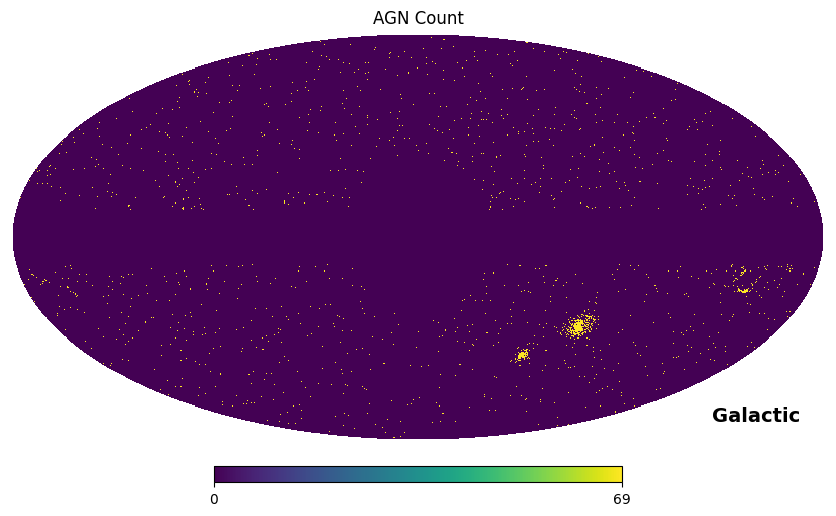

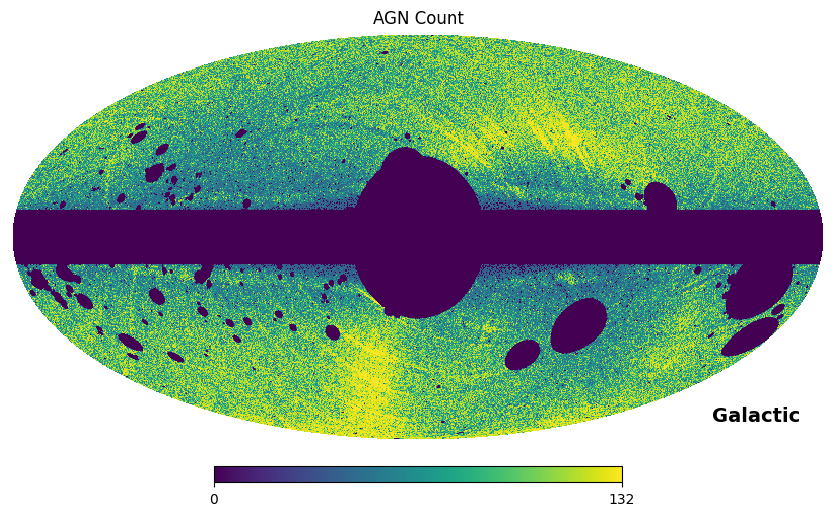

In [53]:
hp.mollview(empty_counts, title="AGN Count", norm='hist',coord='CG')
hp.mollview(empty_wise_counts, title="AGN Count", norm='hist',coord='CG')

In [11]:
hist_table = qc.query('select w1, w2 from mydb://allwise_center_errorcut', fmt = 'pandas')

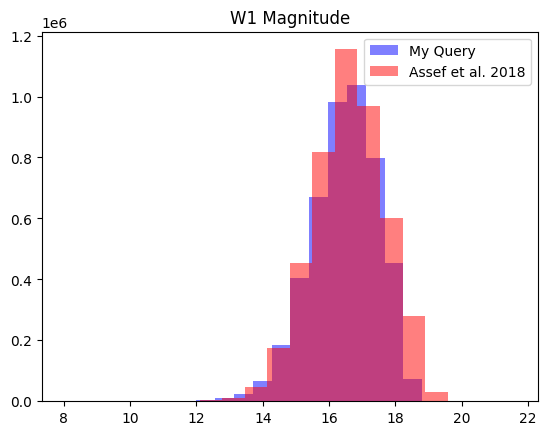

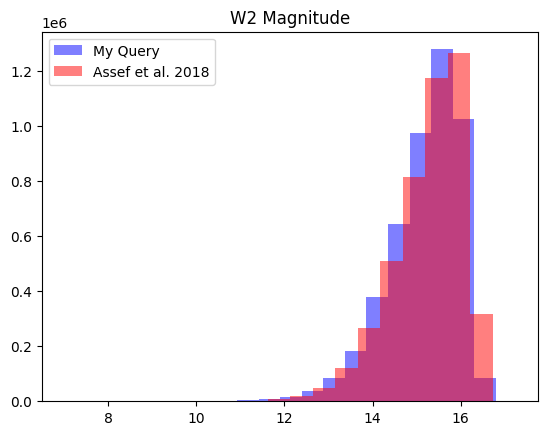

In [12]:
plt.hist(hist_table.loc[:,'w1'], bins = 20,label = "My Query", color = 'b', alpha = 0.5)
plt.hist(wise_data.loc[:,'w1mpro'], bins = 20,label = "Assef et al. 2018", color= 'r',alpha = 0.5)
plt.title("W1 Magnitude")
plt.legend()
plt.show()
plt.hist(hist_table.loc[:,'w2'], bins = 20,label = "My Query", alpha = 0.5, color= 'b')
plt.hist(wise_data.loc[:,'w2mpro'], bins = 20,label = "Assef et al. 2018", alpha = 0.5, color= 'r')
plt.title("W2 Magnitude")
plt.legend()
plt.show()

In [21]:
w21_my = hist_table.loc[:,'w2']-hist_table.loc[:,'w1']
w21_assef = wise_data.loc[:,'w2mpro']-wise_data.loc[:,'w1mpro']
w2 = hist_table.loc[:,'w2']
w2_assef =  wise_data.loc[:,'w2mpro']

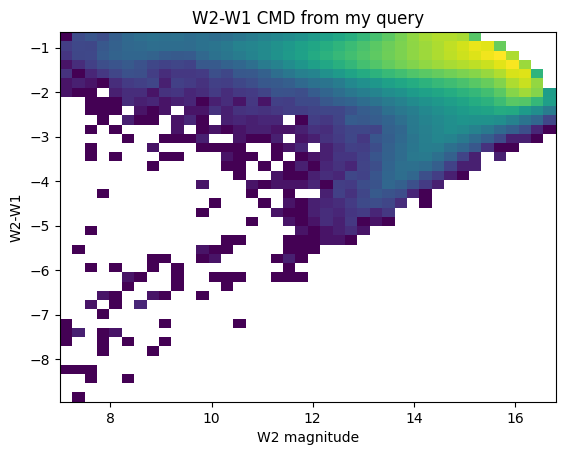

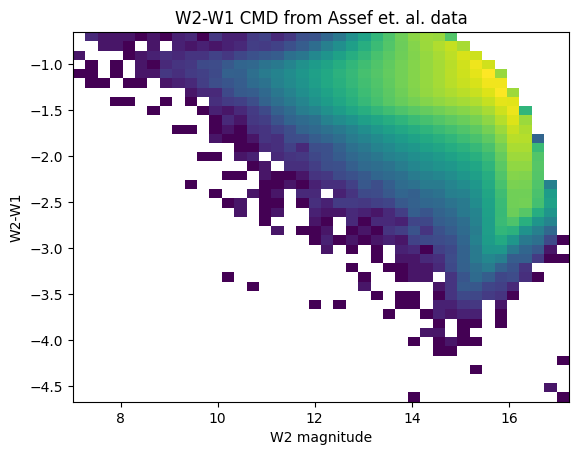

In [43]:
plt.hist2d(w2,w21_my, bins = 40,norm=matplotlib.colors.LogNorm())
plt.title("W2-W1 CMD from my query")
plt.xlabel('W2 magnitude')
plt.ylabel('W2-W1')
plt.show()
plt.hist2d(w2_assef,w21_assef,bins = 40,norm=matplotlib.colors.LogNorm())
plt.title("W2-W1 CMD from Assef et. al. data")
plt.ylabel('W2-W1')
plt.xlabel('W2 magnitude')
plt.show()